In [1]:
using PyPlot
using TimeseriesPrediction

In [2]:
using FFTW, Statistics

In [3]:
import NPZ

In [6]:
include("./MapLattice.jl")

circle_map_ensemble (generic function with 1 method)

In [4]:
function KuramotoSivashinsky(Q, N, tmax, h; M=16, tr=1000)
    #@assert N/λ % 1 == 0 "N/λ % 1 != 0"
    nmax = round(Int,tmax/h)
    x = N*(1:Q) / Q
    #x = N*(-(Q-1)/2:(Q-1)/2) / Q
    u = cos.(π*x/N).*(1 .+sin.(π*x/N))
    v = fft(u)
    #cc= μ* fft(cos.(2π*x/λ))
    #Precompute various ETDRK4 scalar quantities
    #Why all the mean operations?
    k = 2π/N*(0.0:Q-1)
    #k = 2π/N*[(0:(Q/2-1))..., 0, (-Q/2+1:-1)...]
    L = (k.^2 - k.^4) # Fourier Multiples
    E =  exp.(h*L)
    E2 = exp.(h*L/2)
    M = 16 # No. of points for complex means
    r = exp.(im*π*((1:M) .-0.5)/M)
    LR = h*L*ones(M)' + ones(Q)*r'
    QQ = h*real.(mean((exp.(LR/2).-1)./LR, dims=2))[:]
    f1 = h*real(mean((-4 .-LR+exp.(LR).*(4 .-3*LR+ LR.^2))./LR.^3,dims=2))[:]
    f2 = h*real(mean((2 .+LR+exp.(LR).*(-2 .+LR))./LR.^3,dims=2))[:]
    f3 = h*real(mean((-4 .-3*LR-LR.^2+exp.(LR).*(4 .-LR))./LR.^3,dims=2))[:]
    g = -0.5im*k
    #g = 0.5im*k*Q
    uu = [u]
    tt = [0.]

    T = plan_fft(v)
    Ti = plan_ifft(v)
    T! = plan_fft!(v)
    Ti! = plan_ifft!(v)
    a = Complex.(zeros(Q))
    b = Complex.(zeros(Q))
    c = Complex.(zeros(Q))
    Nv = Complex.(zeros(Q))
    Na = Complex.(zeros(Q))
    Nb = Complex.(zeros(Q))
    Nc = Complex.(zeros(Q))
    tmp = Complex.(zeros(Q))

    for n = 1:nmax+tr
                            Nv .= g .* (T*real(Ti*v).^2) #.+ cc
        @.  a  =  E2*v + QQ*Nv
                           Na .= g .* (T!*real(Ti!*a).^2) #.+ cc
        @. b  =  E2*v + QQ*Na
                            Nb .= g.* (T!*real(Ti!*b).^2) #.+ cc
        @. c  =  E2*a + QQ*(2Nb-Nv)
        Nc .= g.* (T!*real(Ti!*c).^2) #.+ cc
        @. v =  E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
        if n > tr
            t = n*h
            u = real(Ti*v)
            push!(uu,u)
            push!(tt,t)
        end
    end
    return uu,tt
end

KuramotoSivashinsky (generic function with 1 method)

In [5]:
Ntrain = 10000
p = 100
N = Ntrain + p

U, T = KuramotoSivashinsky(64, 22, N÷4, 0.25)
summary(U)

"10101-element Vector{Vector{Float64}}"

In [6]:
size(U)

(10101,)

In [7]:
# ### Temporal prediction of field U
Q = length(U[1]) # spatial length
pool = U[1:Ntrain]
test = U[Ntrain:N]

γ = 10
τ = 1
B = 10
k = 1
ntype = FixedMassNeighborhood(4)
method = AverageLocalModel()

em = cubic_shell_embedding(pool, γ,τ,B,k,PeriodicBoundary())
pcaem= PCAEmbedding(pool,em)

@time pred = temporalprediction(pool,pcaem, p;ntype=ntype, method=method, progress = false)

err = [abs.(test[i]-pred[i]) for i=1:p+1]
println("Maximum error: ", maximum(maximum(e) for e in err))

┌ Warning: FixedMassNeighborhood is deprecated in favor of NeighborNumber.
└ @ DelayEmbeddings /Users/adamrupe/.julia/packages/DelayEmbeddings/DdOZb/src/deprecate.jl:175


  3.767109 seconds (4.75 M allocations: 404.125 MiB, 9.39% gc time, 63.42% compilation time)
Maximum error: 12.331146613346936


In [8]:
# Deduce field extremal values
vmax = max(maximum(maximum(s) for s in test),
           maximum(maximum(s) for s in pred))
vmin = min(minimum(minimum(s) for s in test),
           minimum(minimum(s) for s in pred))

# Transform data for imshow
ptest = cat(test..., dims = 2)
ppred = cat(pred..., dims = 2)
perr = cat(err..., dims = 2);

In [37]:
size(ppred[:, 1:end-1])

(64, 100)

In [38]:
size(ptest)

(64, 101)

In [39]:
staf_pred = NPZ.npzread("staf_KS_3.npy")
size(staf_pred)

(64, 101)

In [40]:
lcs_pred = NPZ.npzread("lcs_KS.npy")
size(lcs_pred)

(64, 101)

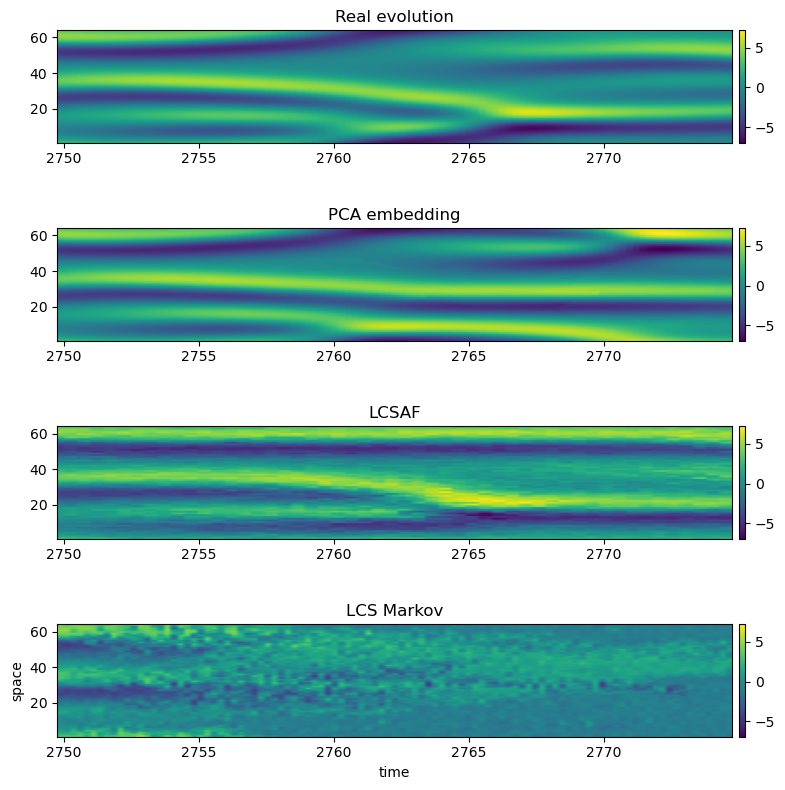

In [54]:
# plot plot plot
fig = figure(figsize=(8,8))
ax1 = subplot2grid((4,1), (0,0))
ax2 = subplot2grid((4,1), (1,0))
ax3 = subplot2grid((4,1), (2,0))
ax4 = subplot2grid((4,1), (3,0));

im1 = ax1[:imshow](ptest, cmap="viridis", vmin = vmin, vmax = vmax,
aspect = "auto", extent = (T[Ntrain], T[N], 1, Q))
im2 = ax2[:imshow](ppred, cmap="viridis", vmin = vmin, vmax = vmax,
aspect = "auto", extent = (T[Ntrain], T[N], 1, Q))
im3 = ax3[:imshow](staf_pred, cmap="viridis", vmin = vmin, vmax = vmax,
aspect = "auto", extent = (T[Ntrain], T[N], 1, Q))
im4 = ax4[:imshow](lcs_pred, cmap="viridis", vmin = vmin, vmax = vmax,
aspect = "auto", extent = (T[Ntrain], T[N], 1, Q))

for (j, (im, ax)) in enumerate(zip([im1,im2,im3,im4], [ax1,ax2,ax3,ax4]))
    colorbar(im, ax = ax, fraction=0.04, pad=0.01)# format="%.1f")
#     if j < 3
#         ax[:set_xticklabels]([])
#     end
end
ax1[:set_title]("Real evolution")
ax2[:set_title]("PCA embedding")
ax3[:set_title]("LCSAF")
ax4[:set_title]("LCS Markov")

ax4[:set_ylabel]("space")
ax4[:set_xlabel]("time")
tight_layout(w_pad=0.1, h_pad=3.0)

In [ ]:
# # plot plot plot
# fig = figure(figsize=(8,8))
# ax1 = subplot2grid((3,1), (0,0))
# ax2 = subplot2grid((3,1), (1,0))
# ax3 = subplot2grid((3,1), (2,0));

# im1 = ax1[:imshow](ppred, cmap="viridis", vmin = vmin, vmax = vmax,
# aspect = "auto", extent = (T[Ntrain], T[N], 1, Q))
# im2 = ax2[:imshow](staf_pred, cmap="viridis", vmin = vmin, vmax = vmax,
# aspect = "auto", extent = (T[Ntrain], T[N], 1, Q))
# im3 = ax3[:imshow](ptest, cmap="viridis", vmin = vmin, vmax = vmax,
# aspect = "auto", extent = (T[Ntrain], T[N], 1, Q))

# for (j, (im, ax)) in enumerate(zip([im1,im2,im3], [ax1,ax2,ax3]))
#     colorbar(im, ax = ax, fraction=0.04, pad=0.01)# format="%.1f")
#     if j < 3
#         ax[:set_xticklabels]([])
#     end
# end
# ax1[:set_title]("Prediction")
# ax2[:set_title]("STAF")
# ax3[:set_title]("Real evolution")

# ax2[:set_ylabel]("space")
# ax3[:set_xlabel]("time")
# tight_layout(w_pad=0.1, h_pad=0.00001)

In [ ]:
# # plot plot plot
# fig = figure(figsize=(8,8))
# ax1 = subplot2grid((3,1), (0,0))
# ax2 = subplot2grid((3,1), (1,0))
# ax3 = subplot2grid((3,1), (2,0));

# im1 = ax1[:imshow](ppred, cmap="viridis", vmin = vmin, vmax = vmax,
# aspect = "auto", extent = (T[Ntrain], T[N], 1, Q))
# im2 = ax2[:imshow](ptest, cmap="viridis", vmin = vmin, vmax = vmax,
# aspect = "auto", extent = (T[Ntrain], T[N], 1, Q))
# im3 = ax3[:imshow](perr, cmap="inferno", vmin = 0, vmax = vmax-vmin,
# aspect = "auto", extent = (T[Ntrain], T[N], 1, Q))

# for (j, (im, ax)) in enumerate(zip([im1,im2,im3], [ax1,ax2,ax3]))
#     colorbar(im, ax = ax, fraction=0.04, pad=0.01)# format="%.1f")
#     if j < 3
#         ax[:set_xticklabels]([])
#     end
# end
# ax1[:set_title]("Prediction")
# ax2[:set_title]("Real evolution")
# ax3[:set_title]("Absolute error")

# ax2[:set_ylabel]("space")
# ax3[:set_xlabel]("time")
# tight_layout(w_pad=0.1, h_pad=0.00001)

In [13]:
size(ptest)

(64, 101)

In [21]:
size(pool)

(10000,)

In [10]:
ppool = vcat(pool...)
size(ppool)

(640000,)

In [11]:
ppool = reshape(ppool, (64,10000));

In [12]:
ppool[:, 2] == pool[2]

true

In [14]:
# NPZ.npzwrite("KS_train.npy", ppool)

In [ ]:
cml_field = NPZ.npzread("map_lattice_train.npy")
size(cml_field)

In [27]:
initial = rand(64*2);
cml_field = map_lattice(initial, 5_000, circle_map; coupling=1.0, nonlinearity=1.0);

In [28]:
size(cml_field)

(5001, 128)

In [29]:
cml_train = []
for t in 1:5001
    push!(cml_train, convert(Array{Float64,1},cml_field[t, :]))
end
summary(cml_train)

"5001-element Vector{Any}"

In [30]:
size(cml_train[1])

(128,)

In [31]:
cml_train = convert(Array{Array{Float64,1}}, cml_train);
summary(cml_train)

"5001-element Vector{Vector{Float64}}"

In [32]:
γ = 4
τ = 1
B = 6
k = 1
ntype = FixedMassNeighborhood(4)
method = AverageLocalModel()

em = cubic_shell_embedding(cml_train, γ,τ,B,k,PeriodicBoundary())
pcaem= PCAEmbedding(cml_train,em)

p = 200

@time pred = temporalprediction(cml_train,pcaem, p;ntype=ntype, method=method, progress = false)

┌ Warning: FixedMassNeighborhood is deprecated in favor of NeighborNumber.
└ @ DelayEmbeddings /Users/adamrupe/.julia/packages/DelayEmbeddings/DdOZb/src/deprecate.jl:175


  1.668032 seconds (1.40 M allocations: 365.759 MiB, 3.04% gc time, 37.39% compilation time)


201-element Vector{Vector{Float64}}:
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
 [0.0, 0.0, 0.0, 0